# Industry Accelerators - Loan Default Prediction Model
## Introduction
The purpose of this notebook is to read in the feature set built in the `1-feature-engineering` notebook, prepare the data for the predictive model, train the model, and then deploy that model. <br> This model predicts if loan customers will default on their loan within the next 12 months. The model can help businesses to interact with loan customers who are suspected of being unable to replay their loan in full. Proper intervention in the form of a restructured loan, for example, allows businesses to recoup the full value owed to them. Specifically, this model makes this prediction by finding patterns in customers' __transactional__ and __savings__ history, as well as looking at some of the characteristics of the __loan__ itself. <br>

The model input data is at the monthly level. Therefore, predictions are also made on a __per month basis__.  <br>

This notebook is organized in the following fashion: <br>
0) Import required libraries and data <br>
1) Data preprocessing steps <br>
2) Feature selection <br>
3) Build XGBoost model and evaluate model performance <br>
4) Deploy model via Watson Machine Learning

**Sample Materials, provided under license. <br>
Licensed Materials - Property of IBM. <br>
© Copyright IBM Corp. 2020. All Rights Reserved. <br>
US Government Users Restricted Rights - Use, duplication or disclosure restricted by GSA ADP Schedule Contract with IBM Corp.<br>**

## 0. Import Libraries and Data
### 0.1 Install proper library version

The pre-installed version of scikit-learn is "0.22.1" The version of scikit-learn that is needed for compatibility across all components of this accelerator is "0.20.2" <br>
The line of code below will change version of scikit-learn. <br>
Additional information about version compatibility can be found [here](https://cloud.ibm.com/docs/ai-openscale?topic=ai-openscale-behavior-drift-config#behavior-drift-config-steps-ntbk).


In [33]:
!pip install scikit-learn==0.20.2 yellowbrick==1.1


After running this cell, the kernel needs to be restarted.
This can be done by clicking on **Kernel** then **Restart** in the toolbar above. <br>
Once the kernel is restarted, the cell above can be skipped, and the rest of the notebook can be run as is.

### 0.2 Import Libraries 
Import Python libraries that will be needed for data preperations and model building. All of these libraries are pre-installed in Cloud Pak 4 Data.

In [34]:
# import libraries

import pandas as pd
pd.set_option('display.max_columns', 100)
import numpy as np
import sys
import os

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import datetime

from sklearn.feature_selection import f_classif, chi2
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, RobustScaler#,\
                                 # PolynomialFeatures, PowerTransformer, LabelBinarizer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, GroupKFold
from sklearn.metrics import classification_report, accuracy_score, f1_score, average_precision_score,\
                            precision_score, recall_score, precision_recall_curve,\
                            roc_auc_score, make_scorer, confusion_matrix
from sklearn.compose import make_column_transformer
import sklearn
import xgboost as xgb

from yellowbrick.classifier import DiscriminationThreshold

from IPython.display import Image

# READING AND WRITING PROJECT ASSETS
import project_lib
project = project_lib.Project()

### 0.3 Read in data for training and validating
There are predefined training and validation sets called `df_training.csv` and `df_validation.csv` in the `/project_data/data_asset/` folder. <br> Alternatively, these files can be accessed by clicking on the `0100` tab in the top right corner, finding the desired files, and clicking `Insert to code`, then `Insert pandas DataFrame`. 

In [35]:
# predefined training and validating sets
# this is from a newer version

df_training = pd.read_csv(project.get_file('df_training.csv'))
print(df_training.shape)
df_validation = pd.read_csv(project.get_file('df_validation.csv'))
print(df_validation.shape)

(6361, 56)
(2108, 56)


### 0.4 Custom Functions and Thresholds
Define some high level parameters that will be used throughout the notebook. <br>
Write custom functions now to help analysis later on in this notebook. <br> 

In [36]:
ANOVA_THRESHOLD = 0.10 # p-value for ANOVA test
CHI2_THRESHOLD = 0.10 # p-value for Chi2 Test of Independence
MISSING_THRESHOLD = .6 # threshold for missing values
CORRELATION_THRESHOLD = 0.7 # maximum amount for correlation coefficient between two features
DECISION_THRESHOLD = .21 # threshold for determining default/nondefault

In [37]:
# helper functions

# FEATURE SELECTION
def correlation_heatmap(data, features, annot=True):
    fig, ax = plt.subplots(figsize=(13,13)) 
    fig = sns.heatmap(data[features].corr(), vmin=-1, vmax=1, center=0,
                     cmap=sns.diverging_palette(20, 220, n=200),
                     square=True,
                     annot=annot, ax=ax)

    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right');
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
    
def test_anova(data, features, target):
    """
    Compute f-statistic and p-value, returns result in a dataframe,
    and displays it with rows where null hypothesis is accepted colored in red.
    - features, target can be either a list of features and a label (as string), or a list of features and a vector 
    """
    f, pval = f_classif(data[features], data[target])
    result = pd.DataFrame(index=features, data={'f-statistic': f, 'p-value': pval})\
               .sort_values('f-statistic', ascending=False)
    color_fail_red = lambda v: 'color: %s' % ('red' if v > ANOVA_THRESHOLD else 'green')
    display(result.style.applymap(color_fail_red, subset='p-value').format("{:.2f}"))
    return result

def test_chi2(data, features, target):
    data = data.copy() # do not modify original dataframe
    # if categoricals are raw strings and not encoded, take care of encoding:
#     to_encode = [c for c in features if c not in data[cat_features].select_dtypes('number').columns]
#     data[to_encode] = OrdinalEncoder().fit_transform(data[to_encode])
    
    # run the test:
    chi2val, pval = chi2(data[features], data[target])
    result = pd.DataFrame(index=features, data={'chi2-statistic': chi2val, 'p-value': pval}).sort_values('p-value')
    color_fail_red = lambda v: 'color: %s' % ('red' if v > CHI2_THRESHOLD else 'green')
    display(result.style.applymap(color_fail_red, subset='p-value').format("{:.2f}"))
    return result

def plot_hist_feature(data, feature, target, kde=True, hist=True, title=''):
    q01 = data[feature].quantile(0.01)
    q99 = data[feature].quantile(0.99)
    for y in sorted(data[target].unique()): # sort to ensure colors are always consistent
        data_to_plot = data.loc[(data[feature].between(q01, q99)) & (data[target] == y), feature]
        sns.distplot(data_to_plot, label=f"{target}={y}", kde=kde, hist=hist)
    plt.title(title)
    plt.legend();

    
# MODEL SELECTION

def print_classification_report(y, y_pred, y_score=None, header='training'):
    print(f'======== {header.upper()} ========')
    print(classification_report(y, y_pred))
    if y_score is not None:
        print(f'ROC AUC: {roc_auc_score(y, y_score):.2f}')
        print(f'AP: {average_precision_score(y, y_score):.2f}')



## 1. Preprocessing of data
Now that the training and validation data are loaded, they can be split into `features` and `target`. The features will have the prefix `X_` and the target will have the prefix `y_`. Reminder that the feature set `X_` is a matrix, and the target `y_` is a vector. <br>
The main function of data preprocessing is to ensure the data is prepared for a model. This includes tasks like imputation for missing values, scaling, and encoding categorical variables.
### 1.1 Split data into features and label
The training and validation sets are predefined from the `1-feature-engineering` notebook. 

In [38]:
# drop any information that the model will not have access to at training time

X_train, y_train = df_training.drop(['default_12mth', 'default', 'date_of_default', 'date_of_last_payment', 'default_12mth'], axis=1), df_training['default_12mth']
X_val, y_val = df_validation.drop(['default_12mth', 'default', 'date_of_default', 'date_of_last_payment', 'default_12mth'], axis=1), df_validation['default_12mth']


### 1.2 Make list of feature types for preprocessing
Making lists of features based on the type of data makes it easier to apply different preprocessing for different data types. It will also make performing analysis like ANOVA and Chi-Squared Test of Independence easier later on in this notebook.

In [39]:
# split of column types
# this copy is for the v2 dataframe we have

to_drop = []
index = ['loan_id', 'prediction_date', 'default', 'date_of_default', 'date_of_first_payment', 'date_of_last_payment', 'default_12mth']
features = [c for c in df_training.columns if c not in index + to_drop]
num_features = df_training[features].select_dtypes('number').columns.tolist()
#bool_features = df_training[features].select_dtypes(bool).columns.tolist()
bool_features = [c for c in df_training.nunique()[df_training.nunique() == 2].index.tolist() if c not in index]
cat_features = [c for c in features if c not in num_features + bool_features + to_drop + index]

print(num_features)
print(bool_features)
print(cat_features)

['loan_payment_amount', 'loan_principal', 'loan_duration', 'loan_remaining_principal', 'loan_remaining_principal_pct', 'loan_missing_payments_to_date', 'loan_months_to_maturity', 'loan_age_in_days', 'age_primary', 'age_secondary', 'age_account', 'age_card', 'balance_mean_current_month', 'balance_std_current_month', 'balance_last_current_month', 'balance_std_current_quarter', 'balance_mean_current_year', 'balance_std_current_year', 'balance_kurt_current_year', 'balance_pct_change_qoq_consecutive', 'balance_pct_change_qoq_seasonal', 'balance_mean_current_month_log', 'balance_last_current_month_log', 'balance_std_current_month_log', 'balance_ratio_std_to_mean_current_month', 'balance_ratio_std_to_mean_current_year', 'balance_ratio_std_to_mean_current_month_log', 'balance_ratio_std_to_mean_current_year_log', 'tx_credit_avg_amount', 'tx_debit_avg_amount', 'tx_monthly_avg_credit_count', 'tx_monthly_avg_credit_pct', 'tx_monthly_avg_credit_sum', 'tx_monthly_avg_debit_sum', 'tx_monthly_avg_cash

### 1.3 Remove features with many missing values
In case the feature engineering produces a feature with too many missing values, we will remove it. If more than 60% of a features values are missing, it will not be considered for a model. This threshold can be changed manually in Section 0.4 with MISSING_THRESHOLD. 

In [40]:
# drop columns that are in "features" list and have more columns missing that some threshold

remove_missing_cols = X_train.isna().mean().sort_values(ascending=False).to_frame().rename({0:'Percent_Missing'}, axis=1)
remove_missing_cols = remove_missing_cols.loc[remove_missing_cols['Percent_Missing'] > MISSING_THRESHOLD]
to_drop += remove_missing_cols.index.to_list()
print('Number of features to remove: ', len(to_drop))

Number of features to remove:  0


### 1.4 Build and apply preprocessor
The preprocessing function will apply all the transformations we want over the feature set. Some of these tasks include filling missing values, scaling features so all values are on a similar scale (more important for linear models), and encoding categorical variables using One Hot Encoding. <br> 
Disclaimer: The `categories` list below is based on the `1-feature-engineering` notebook. So if the categories there are changed, they should be changed here accordingly.

In [41]:
# make a list of lists with all the categorical feature names 
# this is needed for the One Hot Encoder

# all values of all categorical features can be found by using the following: 
    
# for i in cat_features:
#     print(f"Feature name: {i.upper()}")
#     print(df_training[i].value_counts(dropna=False))

categories = [['car', 'debt_consolidation', 'home', 'home_improvement'],
              ['B00000001', 'B00000002', 'B00000003', 'B00000004', 'B00000005', 'B00000006', 'B00000007', 'B00000008', 'B00000009', 'B00000010'], 
              ['VISA Signature', 'VISA Standard', 'VISA Infinite'],
              ['Albany', 'Hartford', 'New York', 'Trenton', 'New Haven', 'Newark', 'Yonkers', 'Rochester', 'Danbury'],
              ['NY', 'NJ', 'CT'], 
              ['hotmail', 'outlook', 'gmail', 'yahoo']]

# redefine these lists in case any columns were added to the to_drop list
features = [c for c in df_training.columns if c not in index + to_drop]
num_features = df_training[features].select_dtypes('number').columns.tolist()
#bool_features = df_training[features].select_dtypes(bool).columns.tolist()
bool_features = [c for c in df_training.nunique()[df_training.nunique() == 2].index.tolist() if c not in index]
cat_features = [c for c in features if c not in num_features + bool_features + to_drop + index]

In [42]:
# build preprocessor function
# the make_column_transformer and make_pipeline come from scikit learn library that we imported above 

def define_preprocessor(num_features, cat_features, bool_features):
    
    # divide the features into lists so we can apply different transformations on them
    # different features may require different types of imputation
    
    fill_with_zero = [c for c in num_features if 'qoq' in c or 'card' in c] # age_card if they dont have a card
    fill_with_three = [c for c in num_features if 'kurt' in c] # filling kurtosis features with 3 because 3 means normally distributed
    fill_with_median = [c for c in num_features if c not in fill_with_zero + fill_with_three] # all others numerical features will be filled with median value
    
        
    scaler = RobustScaler(quantile_range=(0.01, 0.99))
    # information on Robust Scaler can be found here:(https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html)
    
    # apply the trnasformations desired
    num_features_preprocessing = make_column_transformer(
                                    (make_pipeline(SimpleImputer(strategy='constant', fill_value=0), scaler), fill_with_zero),
                                    (make_pipeline(SimpleImputer(strategy='constant', fill_value=3), scaler), fill_with_three),
                                    (make_pipeline(SimpleImputer(strategy='median'), scaler), fill_with_median),
                                   remainder='drop')

    # use OneHotEncoding for numerical columns
    cat_features_preprocessing = make_column_transformer(
                                    (make_pipeline(SimpleImputer(strategy='constant', fill_value='unknown'), OneHotEncoder(categories=categories, sparse=False, handle_unknown='ignore')), cat_features), 
                                    remainder='drop')
    
    # use OrdinalEncoding for boolean columns
    bool_features_preprocessing = make_column_transformer(
                                    (make_pipeline(OrdinalEncoder(), SimpleImputer(strategy='constant', fill_value=1)), bool_features), 
                                    remainder='drop')  

    
    preprocessor = make_column_transformer(
                     (cat_features_preprocessing, cat_features),
                     (num_features_preprocessing, num_features), 
                     (bool_features_preprocessing, bool_features),
                     remainder='drop')

    # this helps us get the names back, used particularly for feature importance
    num_features_reordered = fill_with_zero + fill_with_three + fill_with_median
    
    return preprocessor, num_features_reordered



In [43]:
# apply the preprocessor to all columns

preprocessor_1, num_features_reordered = define_preprocessor(num_features, cat_features, bool_features)

In [44]:
# look at the data after its been transformed

X_train_preprocessed_numerical = preprocessor_1.transformers[1][1].fit_transform(df_training[num_features_reordered])
X_train_preprocessed_numerical = pd.DataFrame(data=X_train_preprocessed_numerical, columns=num_features_reordered, index=df_training.index)#.join(y_train.to_frame('default_12mth'))

X_train_preprocessed_categorical = preprocessor_1.transformers[0][1].fit_transform(df_training[cat_features])
cat_feature_names = preprocessor_1.transformers[0][1].transformers_[0][1].named_steps['onehotencoder'].get_feature_names(cat_features)
X_train_preprocessed_categorical = pd.DataFrame(data=X_train_preprocessed_categorical, columns=cat_feature_names, index=df_training.index)#.join(y_train.to_frame('default_12mth'))
X_train_preprocessed_categorical.head()

X_train_preprocessed_bool = preprocessor_1.transformers[2][1].fit_transform(df_training[bool_features])
X_train_preprocessed_bool = pd.DataFrame(data=X_train_preprocessed_bool, columns=bool_features, index=df_training.index).join(df_training['default_12mth'])

X_train_preprocessed = pd.concat([df_training[['loan_id']], X_train_preprocessed_numerical, X_train_preprocessed_categorical, X_train_preprocessed_bool], axis=1)
feature_set = X_train_preprocessed.columns.tolist()
display(X_train_preprocessed.head())
print(X_train_preprocessed.shape)

loan_id  age_card  balance_pct_change_qoq_consecutive  \
0  L00004959       0.0                            0.057957   
1  L00004959       0.0                           -0.002926   
2  L00004959       0.0                           -0.009541   
3  L00004959       0.0                            0.005927   
4  L00004959       0.0                            0.087549   

   balance_pct_change_qoq_seasonal  balance_kurt_current_year  \
0                        -0.000332                   7.663065   
1                         3.083176                   1.340280   
2                         0.784065                   2.066302   
3                         0.356997                   3.215812   
4                        -0.088318                   9.359245   

   loan_payment_amount  loan_principal  loan_duration  \
0               -501.0       -7.057214          -12.0   
1               -501.0       -7.057214          -12.0   
2               -501.0       -7.057214          -12.0   
3               -501.0       -7.057214          -12.0   
4               -501.0       -7.057214          -12.0   

   loan_remaining_principal  loan_remaining_principal_pct  \
0                -19.505556                          0.33   
1               -206.877778                          0.29   
2               -394.250000                          0.25   
3               -581.622222                          0.20   
4               -768.994444                          0.16   

   loan_missing_payments_to_date  loan_months_to_maturity  loan_age_in_days  \
0                            0.0                      0.0        -42.238422   
1                            0.0                     -1.0        -39.236707   
2                            0.0                     -2.0        -35.913379   
3                            0.0                     -3.0        -32.697256   
4                            0.0                     -4.0        -29.373928   

   age_primary  age_secondary  age_account  balance_mean_current_month  \
0         12.0       2.285714         -1.0                   -0.656744   
1         12.0       2.285714         -1.0                   -0.808679   
2         12.0       2.428571         -1.0                   -0.476739   
3         12.0       2.428571         -1.0                   -0.267302   
4         12.0       2.428571         -1.0                   -0.565136   

   balance_std_current_month  balance_last_current_month  \
0                  -0.325781                   -1.229956   
1                  -1.665102                   -0.738350   
2                  -1.687788                   -0.356248   
3                  -1.493187                   -0.186894   
4                   1.753630                   -1.209731   

   balance_std_current_quarter  balance_mean_current_year  \
0                    -9.858010                  -0.509418   
1                    -9.820661                  -0.394456   
2                    -7.533229                  -0.360011   
3                    -1.536066                  -0.375688   
4                    -8.274663                  -0.437638   

   balance_std_current_year  balance_mean_current_month_log  \
0                  3.331553                       -0.000041   
1                  0.079282                       -0.000053   
2                 -0.315741                       -0.000028   
3                 -0.387814                       -0.000015   
4                 -0.766680                       -0.000034   

   balance_last_current_month_log  balance_std_current_month_log  \
0                       -0.000064                      -0.006952   
1                       -0.000034                      -0.038738   
2                       -0.000015                      -0.039327   
3                       -0.000008                      -0.034330   
4                       -0.000063                       0.033409   

   balance_ratio_std_to_mean_current_month  \
0                                 0.003168   
1  

(6361, 78)


All the imputation, scaling, and encoding has been done and can be observed in the above DataFrame.

## 2.0 Feature Selection
The main purpose of feature selection is to ensure the model uses only features that can best distinguish between default/no-default. This also guarantees the model is less affected by noise/randomness in the features. Some statistical analysis that will be used for feature selection are `ANOVA` (Analysis of Variance), `Chi-Squared Test of Independence`, and `Pearson Correlation`. <br>

In [45]:
if X_train_preprocessed.isna().sum().any() == True:
    raise Exception('Some features contain missing values.')

### 2.1 Run ANOVA test with numerical features on target variable 
This test helps to narrow down which numerical features will be important, and which will not, so features that are not important for the model can be removed to reduce noise. <br> 
Features with small p-values (in this case, p-value < .10) are good candidates for the model, so they will be kept. Features with large p-values will be removed and not included in the model. <br> 
Choosing the p-value threshold is based on heuristics and can be changed in the cells below.

In [46]:
# run anova for all numerical columns
r_anova = test_anova(X_train_preprocessed, [c for c in num_features if c not in to_drop], 'default_12mth')

In [47]:
# add insignificant features to the to_drop list
# the p-value threshold can be tuned since this is based on knowledge of data scientist/statistician

to_drop += r_anova[r_anova['p-value'] >= ANOVA_THRESHOLD].index.tolist()
print('Number of features to remove: ', len(to_drop))

Number of features to remove:  8


### 2.2 Plot correlation matrix
Plot the correlation between all numerical features. This shows the linear relationship between all our features.<br>
It is good practice to remove features that have a strong linear relationship. Gradient boosting algorithms are robust and have few assumptions, so this is not a strict requirement, but for linear models like Logistic Regression, it would be a requirement. 

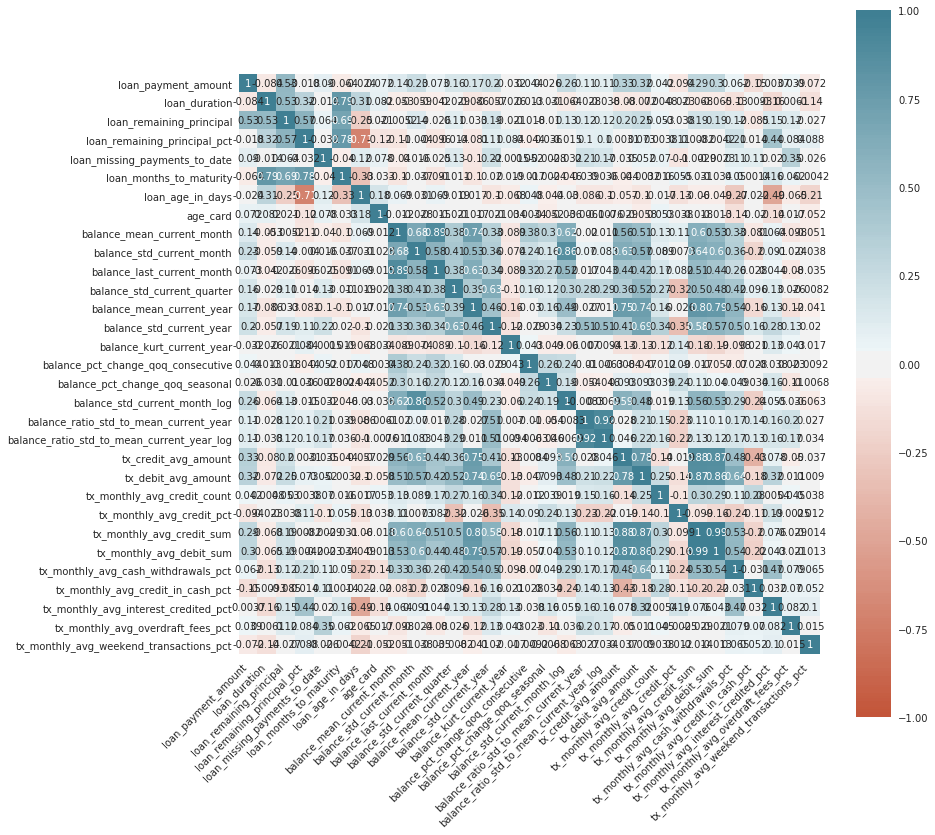

In [48]:
# plot the correlation of all remaining numerical features using the helper function definted in the beginning of this notebook

features_for_correlation = [c for c in num_features if c not in to_drop]
r_corr = correlation_heatmap(X_train_preprocessed, features_for_correlation)

### 2.3 Remove features that are highly correlated
Features that are too highly correlated need to be removed. <br>
The strategy is to calculate the correlation between all numerical features. If two features are highly correlated, then the feature with a smaller f-statistic (and thus higher p-value) from the ANOVA test above will be removed. <br>
The value being used to determine linear independence is R^2 = 0.7. This is based on heuristics and can be changed. For linear models, the threshold should be closer to R^2 = 0.4



In [49]:
# calculate correlation between all significant features 

correlated_features = X_train_preprocessed[features_for_correlation].corr().abs().unstack().sort_values(ascending=False)
correlated_features = correlated_features.reset_index(name='correlation').rename({'level_0': 'feature_1', 'level_1': 'feature_2'}, axis=1)
correlated_features = correlated_features[correlated_features['feature_1'] != correlated_features['feature_2']] # remove duplicate pairs
correlated_features['feature_1_f_stat'] = correlated_features['feature_1'].apply(lambda f: r_anova.loc[f, 'f-statistic'])
correlated_features['feature_2_f_stat'] = correlated_features['feature_2'].apply(lambda f: r_anova.loc[f, 'f-statistic'])
correlated_features.sort_values('correlation', ascending=False).head()

feature_1  \
31                   tx_monthly_avg_credit_sum   
32                    tx_monthly_avg_debit_sum   
33  balance_ratio_std_to_mean_current_year_log   
34      balance_ratio_std_to_mean_current_year   
35                  balance_last_current_month   

                                     feature_2  correlation  feature_1_f_stat  \
31                    tx_monthly_avg_debit_sum     0.988932          9.361776   
32                   tx_monthly_avg_credit_sum     0.988932          6.892735   
33      balance_ratio_std_to_mean_current_year     0.923872        122.996181   
34  balance_ratio_std_to_mean_current_year_log     0.923872        131.394620   
35                  balance_mean_current_month     0.894584         48.789629   

    feature_2_f_stat  
31          6.892735  
32          9.361776  
33        131.394620  
34        122.996181  
35         64.286873

In [50]:
# keep features that are significant AND are not too highly correlated with eachother
# lets change the threshhold to something less aggressive

final_features_numerical = list()
# for new_feature in r.sort_values('f-statistic', ascending=False).index:
for new_feature in features_for_correlation:
    if (correlated_features.loc[(correlated_features['feature_1'] == new_feature) & (correlated_features['feature_2'].isin(final_features_numerical)), 'correlation'].abs() < CORRELATION_THRESHOLD).all():
        if r_anova.loc[new_feature, 'p-value'] < ANOVA_THRESHOLD:
            final_features_numerical.append(new_feature)
print(f"Numerical features that will be kept: {final_features_numerical}")

Numerical features that will be kept: ['loan_payment_amount', 'loan_duration', 'loan_remaining_principal', 'loan_remaining_principal_pct', 'loan_missing_payments_to_date', 'age_card', 'balance_mean_current_month', 'balance_std_current_month', 'balance_std_current_quarter', 'balance_std_current_year', 'balance_kurt_current_year', 'balance_pct_change_qoq_consecutive', 'balance_pct_change_qoq_seasonal', 'balance_ratio_std_to_mean_current_year', 'tx_credit_avg_amount', 'tx_monthly_avg_credit_count', 'tx_monthly_avg_credit_pct', 'tx_monthly_avg_cash_withdrawals_pct', 'tx_monthly_avg_credit_in_cash_pct', 'tx_monthly_avg_interest_credited_pct', 'tx_monthly_avg_overdraft_fees_pct', 'tx_monthly_avg_weekend_transactions_pct']


In [51]:
# add the rest of the numerical columns to the to_drop list

to_drop += [c for c in num_features if c not in to_drop and c not in final_features_numerical]
print('Number of features to remove: ', len(to_drop))

Number of features to remove:  17


### 2.4 Plot correlation map of independent features
Now, the correlation plot should show that all numerical features being kept are linearly independent.

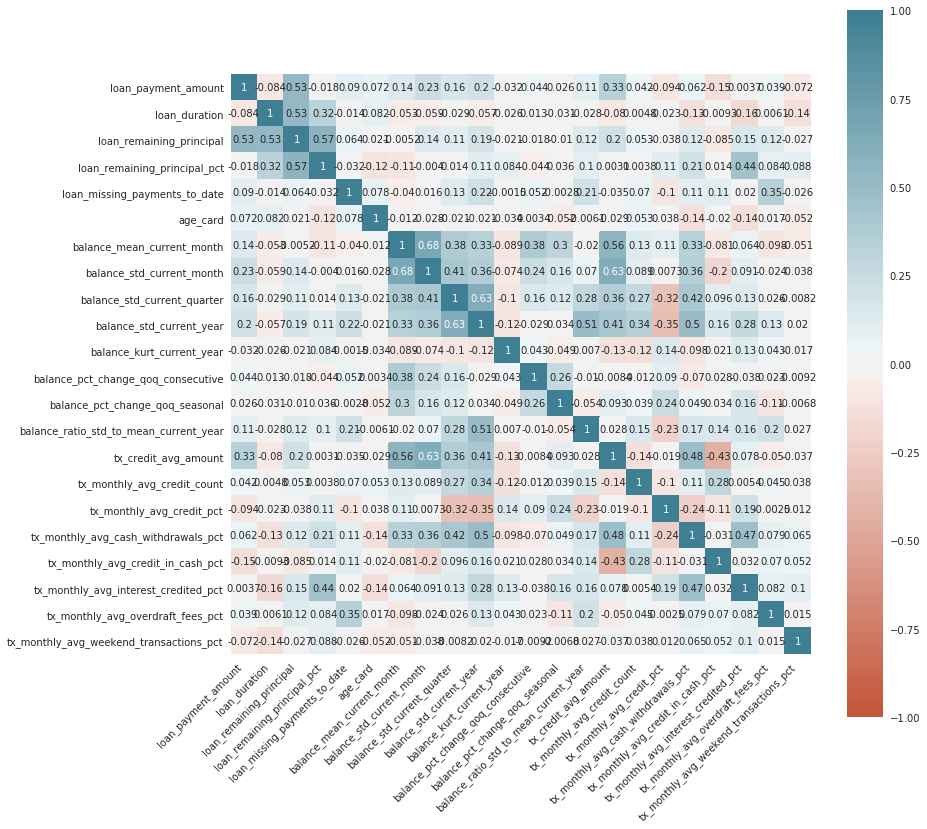

In [52]:
# check that all remaining features are linearly independent

correlation_heatmap(X_train_preprocessed, final_features_numerical)

### 2.5 Chi Squared Test of Independence
Test relationship between categorical features and target variable. <br>
Similar as above, this test helps determine which of the categorical features will best predict distinguish the differene between default/non-default. Features that are not important will be removed to reduce noise. <br>
Features with small p-values (in this case, < .10, from the CHI2_THRESHOLD that was set in Section 0.4) are good candidates for the model, so they will be kept. Features with large p-values will be removed and not included in the model.

In [53]:
r_chi2 = test_chi2(X_train_preprocessed, [c for c in cat_feature_names if c not in to_drop], 'default_12mth')

In [54]:
# add insignificant features to the to_drop list

cat_features_ohe = r_chi2.index.tolist()
to_drop += r_chi2[r_chi2['p-value'] >= CHI2_THRESHOLD].index.tolist()
print('Number of features to remove: ', len(to_drop))

Number of features to remove:  34


In [55]:
# remove features so the model does not overfit

to_drop+=['loan_missing_payments_to_date']

## 2.6 Apply preprocessor to subset of features for modeling
- At this point, some features have been removed and will not be included in the modeling. Thus, the preprocessor is called again, but only on the columns that will be included in the modeling.

In [56]:
sorted([c for c in cat_features_ohe if c not in to_drop])

['branch_city_New Haven',
 'branch_city_New York',
 'branch_city_Newark',
 'branch_id_B00000001',
 'branch_id_B00000006',
 'branch_id_B00000009',
 'debit_card_type_VISA Infinite',
 'debit_card_type_VISA Signature',
 'debit_card_type_VISA Standard',
 'email_service_primary_gmail',
 'email_service_primary_hotmail',
 'email_service_primary_outlook',
 'email_service_primary_yahoo',
 'loan_purpose_car',
 'loan_purpose_home',
 'loan_purpose_home_improvement']

In [57]:
# these lists include only the features we want to keep

num_features_final = [c for c in num_features if c not in to_drop]
# cat_features_final = [c for c in cat_features if any(c in x for x in set(cat_features_ohe) - set(to_drop))] @ programtic approach
cat_features_final = ['loan_purpose', 'branch_id', 'debit_card_type', 'branch_city'] # manual approach if it is known which categories should be kept
bool_features_final = [c for c in bool_features if c not in to_drop]

# make a list of the one hot encoded features we want to keep from chi2 test
categories = [['car', 'home', 'home_improvement'],
              ['B00000001', 'B00000006', 'B00000009'], 
              ['VISA Infinite', 'VISA Signature', 'VISA Standard'],
              ['New Haven', 'New York', 'Newark']]

In [58]:
# call the preprocessor on the filtered lists of features
preprocessor_2, num_features_importances = define_preprocessor(num_features_final, cat_features_final, bool_features_final)

## 3.0 Model Building

By now, the features that should not be included in modeling have been removed. <br>
The cells below fit an XGBoost model. This model is trained on the `X_train` set, and validated on the `X_val` set, which the model does not see during training. <br>
The feature importance is also plotted to help determine what features are the main drivers of predicting default.


### 3.1 Build XGBoost model

In [59]:
# build model 
# apply grid search

classifier = xgb.XGBClassifier(
        eval_metric='aucpr', 
        early_stopping_rounds=25,
        seed=12)

pipe_1 = make_pipeline(preprocessor_2, classifier)

groups = X_train['loan_id']
group_kfold = GroupKFold(n_splits=5)
cv_generator = group_kfold.split(X_train, y_train, groups)

param_grid = {
        'xgbclassifier__min_child_weight': [0],
        'xgbclassifier__n_estimators': np.arange(40, 81, 4),
        'xgbclassifier__learning_rate': np.linspace(.03, .04, 8),
        'xgbclassifier__subsample': np.linspace(.75, .85, 5), 
        'xgbclassifier__colsample_bytree': np.linspace(0.75, 1, 5),
        'xgbclassifier__max_depth': np.arange(3, 5), 
        'xgbclassifier__gamma': [1],
        }

grid_1 = GridSearchCV(pipe_1, param_grid, cv=cv_generator, scoring='f1',
                              n_jobs=-1, verbose=1, return_train_score=True)

grid_1.fit(X_train[[c for c in num_features_final if c not in to_drop]
                   + [c for c in bool_features_final if c not in to_drop]
                   + ['loan_purpose', 'branch_id', 'debit_card_type', 'branch_city']],
           y_train)
#pipe_1.fit(X_train, y_train)
print("Best cross-validation score: {:.2f}".format(grid_1.best_score_))
print("Best parameters: ", grid_1.best_params_)

best_model_1 = grid_1.best_estimator_

Fitting 5 folds for each of 4400 candidates, totalling 22000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   41.9s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 1246 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 1796 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 2446 tasks      | elapsed:  9.8min
[Parallel(n_jobs=-1)]: Done 3196 tasks      | elapsed: 12.9min
[Parallel(n_jobs=-1)]: Done 4046 tasks      | elapsed: 16.3min
[Parallel(n_jobs=-1)]: Done 4996 tasks      | elapsed: 20.3min
[Parallel(n_jobs=-1)]: Done 6046 tasks      | elapsed: 24.8min
[Parallel(n_jobs=-1)]: Done 7196 tasks      | elapsed: 29.7min
[Parallel(n_jobs=-1)]: Done 8446 tasks      | elapsed: 34.9min
[Parallel(n_jobs=-1)]: Done 9796 tasks      | elapsed: 40.8min
[Parallel(n_jobs=-1)]: Done 11246 tasks      |

Best cross-validation score: 0.16
Best parameters:  {'xgbclassifier__colsample_bytree': 1.0, 'xgbclassifier__gamma': 1, 'xgbclassifier__learning_rate': 0.04, 'xgbclassifier__max_depth': 4, 'xgbclassifier__min_child_weight': 0, 'xgbclassifier__n_estimators': 80, 'xgbclassifier__subsample': 0.775}


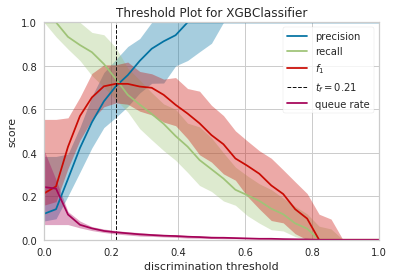

In [60]:
visualizer = DiscriminationThreshold(best_model_1)

visualizer.fit(X_train, y_train)
visualizer.show();                 

### 3.2 Observe model performance on validation set
See how the model performs on the validation set.<br>
Also see how the model does predicting the training set. This helps to tell if the model is overfitting.

In [61]:

y_pred_val = best_model_1.predict_proba(X_val)[:,1] >= DECISION_THRESHOLD
print_classification_report(y_val, y_pred_val, header='validation')

y_pred_train = best_model_1.predict_proba(X_train)[:,1] >= DECISION_THRESHOLD
print_classification_report(y_train, y_pred_train, header='train')


======== VALIDATION ========
              precision    recall  f1-score   support

       False       0.98      0.98      0.98      2039
        True       0.37      0.32      0.34        69

   micro avg       0.96      0.96      0.96      2108
   macro avg       0.67      0.65      0.66      2108
weighted avg       0.96      0.96      0.96      2108

======== TRAIN ========
              precision    recall  f1-score   support

       False       1.00      0.99      1.00      6154
        True       0.83      0.96      0.89       207

   micro avg       0.99      0.99      0.99      6361
   macro avg       0.91      0.97      0.94      6361
weighted avg       0.99      0.99      0.99      6361



### 3.3 Plot feature importance
The feature importance shows how valuable each feature is to the model. <br>
The score on the x-axis is the Gini Importance, (mean decrease in impurity) which looks at node impurity. Node impurity determines how well a tree splits the data. Technically it calculates each feature importance as the sum over the number of splits that include the feature, proportionally to the number of samples it splits. <br>
The greater the value, the more important the feature. 


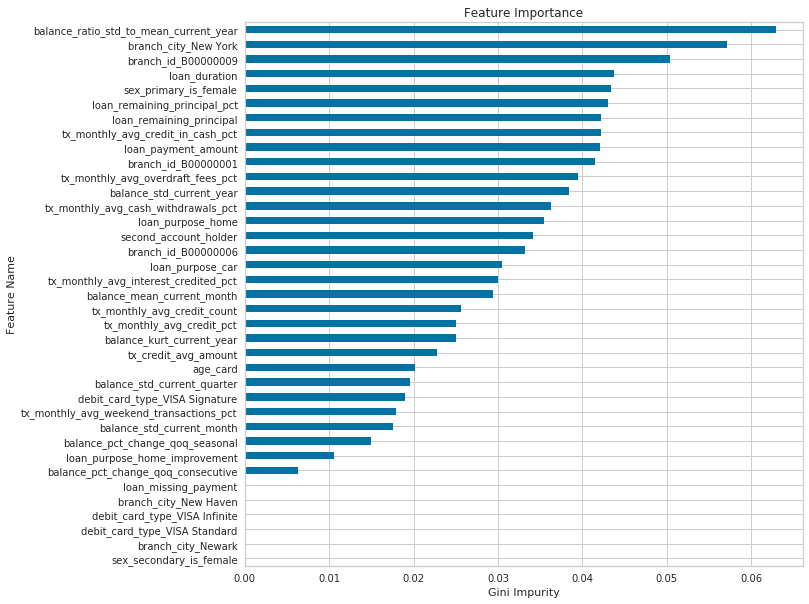

In [62]:
feature_names = preprocessor_2.transformers[0][1].transformers[0][1].named_steps['onehotencoder'].fit(X_train[cat_features_final].dropna()).get_feature_names(cat_features_final).tolist() + num_features_importances + bool_features_final

pd.Series(best_model_1.steps[1][1].feature_importances_, index=feature_names).sort_values().plot(kind='barh', figsize=(10,10))
plt.title('Feature Importance')
plt.xlabel('Gini Impurity')
plt.ylabel('Feature Name')
plt.show()

### 3.4 Save a .csv for cost benefit analysis
Save a .csv file of the predicted probabilities along with some other identifying information for cost benefit analysis.

In [63]:
# Prediction date, loan id, loan amount, the probability of the prediction, and the actual prediction

probabilities = best_model_1.predict_proba(X_val)
predicted_probas = pd.DataFrame(data=probabilities, index=X_val.index, columns=["P(nondefault)", "P(default)"])
predicted_probas = pd.concat([df_validation[['loan_id', 'prediction_date', 'loan_principal', 'default_12mth']], predicted_probas], axis=1)
predicted_probas.head()

loan_id prediction_date  loan_principal  default_12mth  P(nondefault)  \
0  L00004961      2016-08-31         30276.0           True       0.973493   
1  L00004961      2016-09-30         30276.0           True       0.973493   
2  L00004961      2016-10-31         30276.0           True       0.975620   
3  L00004961      2016-11-30         30276.0           True       0.973394   
4  L00004961      2016-12-31         30276.0           True       0.975620   

   P(default)  
0    0.026507  
1    0.026507  
2    0.024380  
3    0.026606  
4    0.024380

## 4.0 Save and Deploy Model to Cloud Pak for Data
Use Watson Machine Learning (WML) to save the model and deploy it for online scoring. <br>

Before we save the model we must create a deployment space. Watson Machine Learning provides deployment spaces where the user can save, configure and deploy their models. We can save models, functions and data assets in this space. <br>

The steps involved in saving and deploying the model are detailed in the following cells. We will use the watson_machine_learning_client package to complete these steps.


### 4.1 User Inputs

The user can specify the name for the space, model and model deployment.

In [64]:
# Specify a name for the saved model and the model deployment
model_name = 'loan_default_model'
deployment_name = 'loan_default_deployment'

In [65]:
from watson_machine_learning_client import WatsonMachineLearningAPIClient
import os

token = os.environ['USER_ACCESS_TOKEN']

wml_credentials = {
   "token": token,
   "instance_id" : "openshift",
   "url": os.environ['RUNTIME_ENV_APSX_URL'],
   "version": "3.0.0"
}

client = WatsonMachineLearningAPIClient(wml_credentials)
# set space ID
space_uid = os.environ['SPACE_ID']
client.set.default_space(space_uid)

'SUCCESS'

### 4.3 Store the Model Details

Store the XGBoost in the deployment space. Again, the name for the model is specified in the user inputs cell above. A default tag for the model is specified in the model metadata.


In [66]:
metadata = {
    client.repository.ModelMetaNames.NAME: model_name,
    client.repository.ModelMetaNames.TYPE: "scikit-learn_0.20",
    client.repository.ModelMetaNames.RUNTIME_UID: "scikit-learn_0.20-py3.6"
}
stored_model_details = client.repository.store_model(model=best_model_1, meta_props=metadata)
stored_model_details

{'metadata': {'name': 'loan_default_model',
  'guid': '9a5a31d6-6be4-40ba-a001-dbea031a4324',
  'id': '9a5a31d6-6be4-40ba-a001-dbea031a4324',
  'modified_at': '2020-10-21T16:20:31.002Z',
  'created_at': '2020-10-21T16:20:30.002Z',
  'owner': '1000331026',
  'href': '/v4/models/9a5a31d6-6be4-40ba-a001-dbea031a4324?space_id=9a05d90c-7e3d-4eca-b1aa-573afa1701f1',
  'space_id': '9a05d90c-7e3d-4eca-b1aa-573afa1701f1'},
 'entity': {'name': 'loan_default_model',
  'content_status': {'state': 'persisted'},
  'space': {'id': '9a05d90c-7e3d-4eca-b1aa-573afa1701f1',
   'href': '/v4/spaces/9a05d90c-7e3d-4eca-b1aa-573afa1701f1'},
  'type': 'scikit-learn_0.20',
  'runtime': {'id': 'scikit-learn_0.20-py3.6',
   'href': '/v4/runtimes/scikit-learn_0.20-py3.6'}}}

### 4.4 Deploy the Model

Deploy the saved model. The deployment name is specified in the user inputs cell above. Again, a default tag for the deployment is specified in the deployment metadata. Similarly, this tag will be used in the future to identify this deployment.


In [67]:
# deploy the model
meta_props = {
    client.deployments.ConfigurationMetaNames.NAME: deployment_name,
    client.deployments.ConfigurationMetaNames.ONLINE: {}    
}

# deploy the model

model_uid = stored_model_details["metadata"]["guid"]
deployment_details = client.deployments.create( artifact_uid=model_uid, meta_props=meta_props)



#######################################################################################

Synchronous deployment creation for uid: '9a5a31d6-6be4-40ba-a001-dbea031a4324' started

#######################################################################################


initializing
ready


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='072d10d4-b5c9-4ebc-b0fe-ddb5d5253b00'
------------------------------------------------------------------------------------------------




### 4.5 Associate the Deployment Space with the Project
To make the new Deployment Space accessible through the Porject UI, it must be associated with this Project. Listed below are some instructions to associate the Deployment Space and Project using the UI.

#### 4.5.1 Go to the Settings tab in the Project
Click on the Settings tab from the Project view **outside of this notebook**


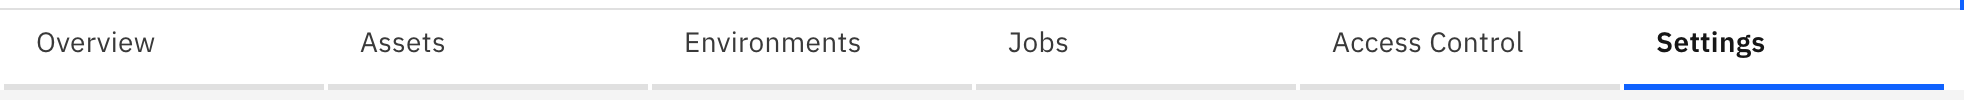

In [68]:
Image(project.get_file('loan_default_UI_1.png').read())

#### 4.5.2 Associate a Deployment Space
Find the section titled, "Associated deployment space" and select "Associate a deployment space"

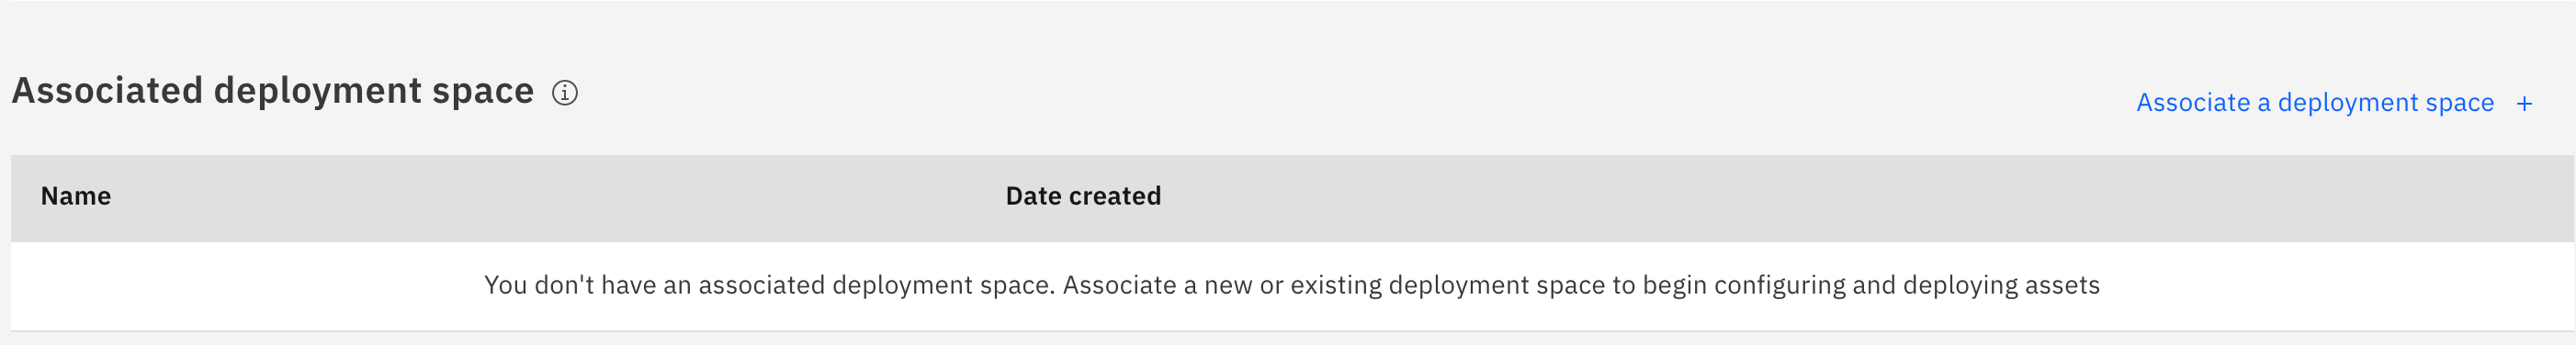

In [69]:
Image(project.get_file('loan_default_UI_2.png').read())

#### 4.5.3 Connect to an Existing Deployment Space
A Deployment Space was already created in Section 4.2 of this notebook. So choose the tab that says "Existing" and the Deployment Space will appear. <br>
Finally, connect the Deployment Space with this Project.

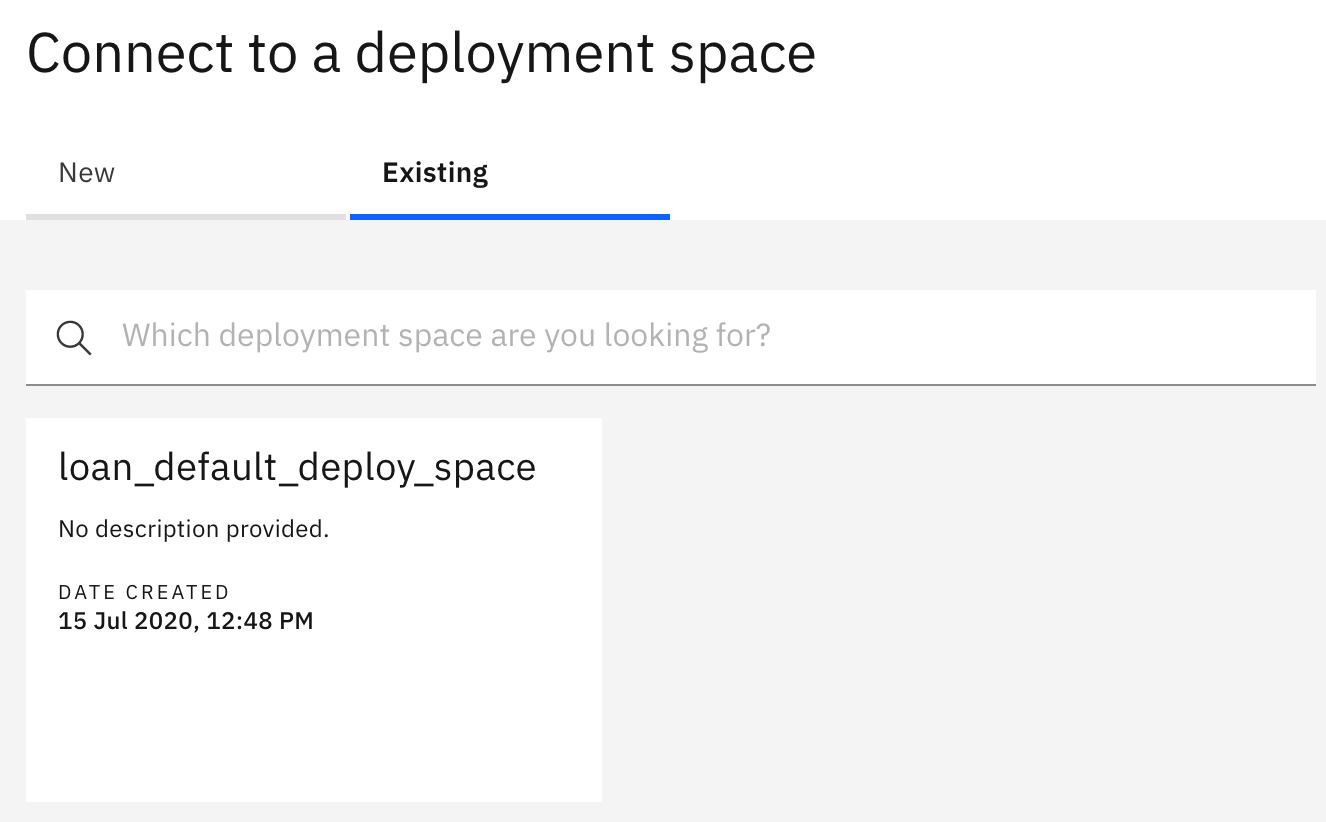

In [70]:
Image(project.get_file('loan_default_UI_3.png').read(), width=800, height=600)